In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os,sys
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import word2vec
from sklearn.ensemble import RandomForestRegressor
import logging

import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [3]:
dir(xgboost)

['__doc__', '__loader__', '__name__', '__package__', '__path__', '__spec__']

In [15]:
path='/Users/mizuseki_hiroto/python_study/mercari/'

df_train=pd.read_csv(path+'train.tsv',delimiter='\t')
df_test=pd.read_csv(path+'test.tsv',delimiter='\t')

In [16]:
display(df_train.head(1))
display(df_test.head(1))

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7


まずはデータの概要把握

In [17]:
#null値を確認すると結構ある。
#特にブランドは40%近くがブランク
display(df_train.isnull().sum())

#
display(len(df_train))
df_train['category_name']=df_train['category_name'].fillna('other/other/other')


train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

1482535

In [18]:
#train_id
#ユニークなのでただのIDでしょう
test=df_train['train_id'].value_counts()
test.sum()==len(test)



True

Bundle      2232
Reserved     453
Converse     445
BUNDLE       418
Dress        410
Name: name, dtype: int64

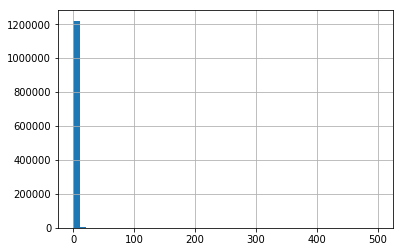

In [19]:
#name
#よく出てくるのはは2000回とか出てくるけど、ヒストグラムを見ると殆どの物は20回以下しかでてこない
#回数と信用は相関ありそう。
#多分商品名
test=df_train['name'].value_counts()
display(test.head())
test.hist(range=(0,500),bins=50)



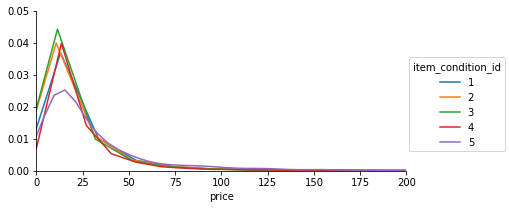

,train_id,price,shipping
item_condition_id,,,
1,741477.869562,26.486967,0.562708
2,740793.371866,27.563225,0.380767
3,741266.541217,26.540711,0.343553
4,743097.620894,24.349212,0.324104
5,734745.646812,31.703859,0.360319


In [20]:
#item_condition_id
#多分アイテムの状態コード。123が多い。多分値段との相関高そう。
df_train['item_condition_id'].value_counts(dropna=False)

#グラフを見ると5以外は大差ない気がする。
fig=sns.FacetGrid(df_train,hue='item_condition_id',aspect=2)
fig.map(sns.kdeplot,'price')
fig.add_legend()
plt.xlim(xmin=0,xmax=200)
plt.ylim(ymin=0,ymax=0.05)
plt.show()

#表で見るとやはり5だけ抜けて高い。あと１だけshippingの値が極端に違う。配送料？？
df_train.groupby('item_condition_id').mean()

In [21]:
#category_name
#大分類中分類小分類という位置づけみたいなので0~2に分けた。
#多分小分類を概念でいくつかのカテゴリーに分けるのがよさそう。
#一般的な言葉(wikiとか？)を学習させたw2vを使ったベクトルを当てはめるのがよい？
df_train['category_name'].value_counts(dropna=False)
df_train['category_0']=df_train['category_name'].apply(lambda x:str(x).split('/')[0])
df_train['category_1']=df_train['category_name'].apply(lambda x:str(x).split('/')[1])
df_train['category_2']=df_train['category_name'].apply(lambda x:str(x).split('/')[2])

In [22]:
#brand_name 
#金額とかなり相関は高そうだけど、ブランク多すぎる。(4割くらい)
#他の文章とかから推定できるならいいけど、できないならモデル2つ作るのもよいかも
df_train['brand_name'].value_counts(dropna=False)

NaN                   632682
PINK                   54088
Nike                   54043
Victoria's Secret      48036
LuLaRoe                31024
Apple                  17322
FOREVER 21             15186
Nintendo               15007
Lululemon              14558
Michael Kors           13928
American Eagle         13254
Rae Dunn               12305
Sephora                12172
Coach                  10463
Disney                 10360
Bath & Body Works      10354
Adidas                 10202
Funko                   9237
Under Armour            8461
Sony                    7994
Old Navy                7567
Hollister               6948
Carter's                6385
Urban Decay             6210
The North Face          6172
Independent             5902
Too Faced               5794
Xbox                    5709
Brandy Melville         5680
Kate Spade              5411
                       ...  
Koss                       1
Signorelli                 1
Focus                      1
Hot Chillys   

In [23]:
df_train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'category_0', 'category_1',
       'category_2'],
      dtype='object')

(0, 250)

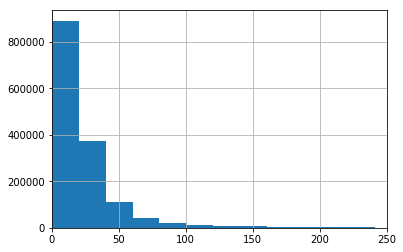

In [24]:
#基本安いものが多いよね、という状態。
df_train['price'].hist(bins=100)
plt.xlim(xmin=0,xmax=250)


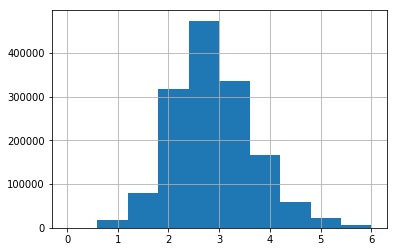

In [25]:
#なので、対数をとって正規分布っぽくする
df_train['price_log']=df_train['price'].apply(lambda x:np.log(x))
df_train['price_log'].hist(range=(0,6))

In [26]:
inf=float('inf')
display(len(df_train))
display(len(df_train[df_train['price_log']==-inf]))
df_train=df_train[df_train['price_log']!=-inf]

1482535

874

0    818876
1    662785
Name: shipping, dtype: int64

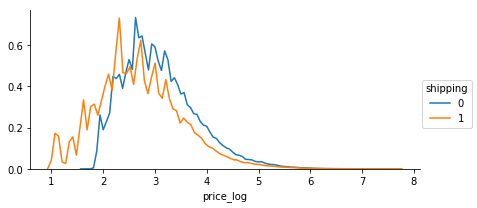

,train_id,item_condition_id,price,price_log
shipping,,,,
0,741052.595640,2.062692,30.132333,3.081274
1,741479.851365,1.715360,22.578452,2.704941


In [27]:
#shippingはただのラベル。値段に影響あるきがする。
display(df_train['shipping'].value_counts(dropna=False))

#shipping安い値段帯に絞るとshipping=0のほうが値段が高そうだが、全ての領域で見るとあまり差はない。
fig=sns.FacetGrid(df_train,hue='shipping',aspect=2)
fig.map(sns.kdeplot,'price_log')
fig.add_legend()
plt.show()

df_train.groupby('shipping').mean()


In [28]:
#商品の説明文のようだが、意外と同じ単語が使われるパターンもあるっぽい。
df_train['item_description'].value_counts()

No description yet                                                                                                                                                                                                                                                                                                                                         82427
New                                                                                                                                                                                                                                                                                                                                                         4099
Brand new                                                                                                                                                                                                                                                                                             

,train_id,item_condition_id,price,shipping,price_log
brand_flag,,,,,
0,741317.659477,1.736947,21.145017,0.525738,2.723124
1,741188.667555,2.034168,30.928735,0.388947,3.054245


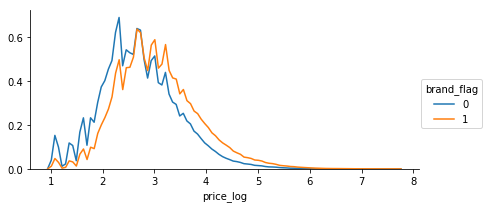

In [29]:
#ブランド名あるなしで判別するとやはりブランド名がある方が平均価格は高い
df_train['brand_flag']=df_train.loc[:,'brand_name'].notnull()*1
display(df_train.groupby('brand_flag').mean())

fig=sns.FacetGrid(df_train,hue='brand_flag',aspect=2)
fig.map(sns.kdeplot,'price_log')
fig.add_legend()
plt.show()


In [30]:
#名前は要素を分解すると頻出する単語があるみたい。
df_train['name'].value_counts()
list1=[t. split(' ') for t in df_train['name']]
list2=np.concatenate(list1)
list2=[t.lower() for t in list2]
pd.Series(list2).value_counts()

pink                         81517
bundle                       72295
size                         71543
new                          68341
lularoe                      63133
for                          58815
black                        53259
and                          46135
nike                         45867
vs                           43318
secret                       40189
dress                        37476
&                            37337
leggings                     37177
nwt                          36136
set                          34987
top                          34598
free                         33359
2                            33061
shirt                        31409
iphone                       29931
of                           25766
case                         25270
shorts                       24349
victoria's                   23674
jeans                        21269
white                        20879
3                            20432
the                 

In [76]:
#まずはざっくり数値にする、数値にできないものは削除する関数を作成
def  changer_train(df):
    df[df['category_name'].isnull()]='//'
    df['category_0'],df['category_1'],df['category_2']=zip(*df['category_name'].apply(lambda x:str(x).split('/')))
    df['brand_flag']=df.loc[:,'brand_name'].notnull()*1
    df['price_log']=df['price'].apply(lambda x:np.log(x))

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for word in ['category_0','category_1','category_2']:
        le.fit(df[word])
        df[word]=le.fit_transform(df[word])
    df=df.drop(['train_id','name','category_name','brand_name','item_description','price'],axis=1)
    return(df)
    
#まずはざっくり数値にする、数値にできないものは削除する関数を作成
def  changer_test(df):
    df[df['category_name'].isnull()]='//'
    df['category_0'],df['category_1'],df['category_2']=zip(*df['category_name'].apply(lambda x:str(x).split('/')))
    df['brand_flag']=df.loc[:,'brand_name'].notnull()*1

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for word in ['category_0','category_1','category_2']:
        le.fit(df[word])
        df[word]=le.fit_transform(df[word])
    df=df.drop(['test_id','name','category_name','brand_name','item_description'],axis=1)
    return(df)
    



In [77]:
df_train_1=changer_train(df_train)
from sklearn.ensemble import RandomForestRegressor
clf=RandomForestRegressor()
X=df_train_1.drop('price_log',axis=1)
y=df_train_1['price_log']
clf.fit(X,y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [87]:
print('socre is',clf.score(X,y))
pd.DataFrame({'y':np.exp(1)**y,'y_hat':np.exp(1)**clf.predict(X)}).T

,0,1,2,3,4,5,6,7,8,9,...,1482525,1482526,1482527,1482528,1482529,1482530,1482531,1482532,1482533,1482534
y,10.000000,52.000000,10.000000,35.000000,44.000000,59.000000,64.000000,6.000000,19.000000,8.000000,...,7.000000,12.000000,10.000000,18.000000,34.000000,20.000000,14.000000,12.000000,45.000000,22.000000
y_hat,9.859765,28.110393,15.488895,10.752346,15.022674,21.166912,15.639876,11.246342,13.091398,23.049305,...,14.920355,14.748044,13.677638,14.883721,15.219968,25.992067,13.279099,17.764445,11.206664,19.518715


In [89]:
def  changer_train_notlog(df):
    df[df['category_name'].isnull()]='//'
    df['category_0'],df['category_1'],df['category_2']=zip(*df['category_name'].apply(lambda x:str(x).split('/')))
    df['brand_flag']=df.loc[:,'brand_name'].notnull()*1
    df['price_log']=df['price'].apply(lambda x:np.log(x))

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    for word in ['category_0','category_1','category_2']:
        le.fit(df[word])
        df[word]=le.fit_transform(df[word])
    df=df.drop(['train_id','name','category_name','brand_name','item_description','price_log'],axis=1)
    return(df)

In [90]:
df_train_2=changer_train_notlog(df_train)

In [92]:
clf2=RandomForestRegressor()
X=df_train_2.drop('price',axis=1)
y=df_train_2['price']
clf2.fit(X,y)
print('socre is',clf2.score(X,y))
pd.DataFrame({'y':y,'y_hat':clf2.predict(X)}).T

socre is 0.234496352193


,0,1,2,3,4,5,6,7,8,9,...,1482525,1482526,1482527,1482528,1482529,1482530,1482531,1482532,1482533,1482534
y,10.000000,52.000000,10.000000,35.000000,44.000000,59.000000,64.000000,6.000000,19.000000,8.000000,...,7.00000,12.000000,10.000000,18.00000,34.000000,20.000000,14.000000,12.000000,45.000000,22.000000
y_hat,11.633134,39.767994,19.429902,13.798658,18.590035,28.587513,18.398224,12.832092,14.357581,32.165158,...,17.08236,17.361959,16.726825,17.14378,17.040255,31.434718,14.322251,23.107563,13.676555,25.906921


In [93]:
dir(xgboost)

['__doc__', '__loader__', '__name__', '__package__', '__path__', '__spec__']

AttributeError: module 'xgboost' has no attribute 'xgboost'